In [33]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize


from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

%matplotlib inline

In [49]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

dictionary=np.load("../grid_metadata/dictionary.npy")
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]    
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [50]:
# cut out anomalistic portions of parameter space - high gamma, high logMenv
cube_cut=[]
nancube_cut=[]

for i in range(len(cube)):
    if dictionary[i]["gamma"]<1.5 and dictionary[i]["logM_env"]<-4:
        cube_cut.append(cube[i])
        nancube_cut.append(nancube[i])
        
cube=cube_cut
nancube=nancube_cut

np.array(cube).shape

(1975, 400)

In [51]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.034s


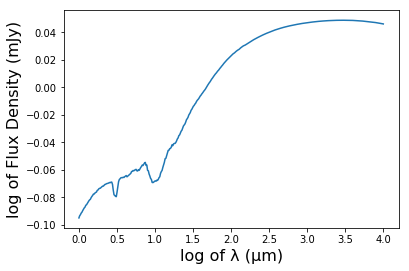

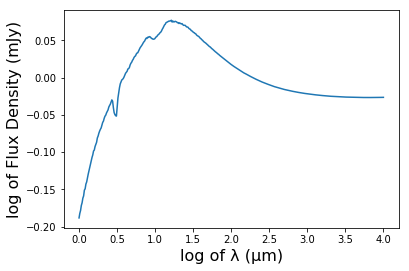

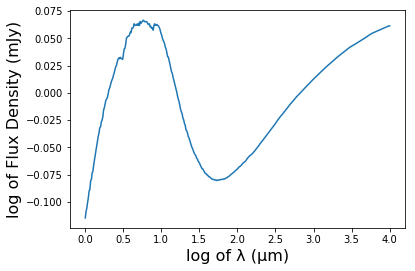

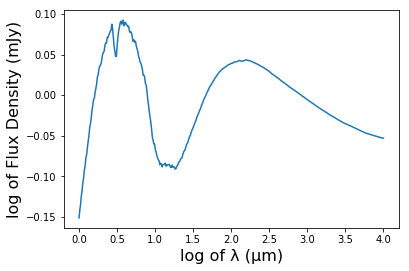

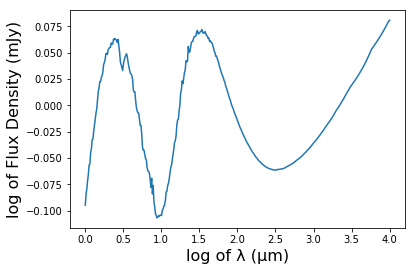

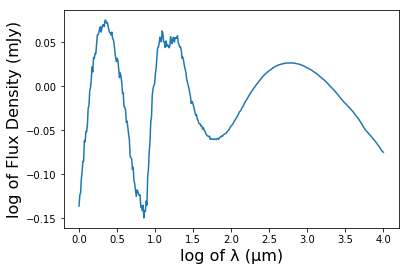

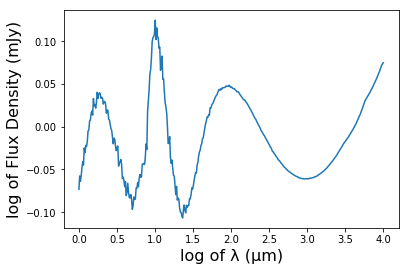

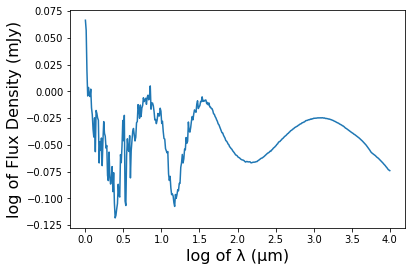

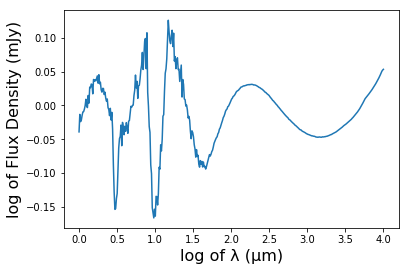

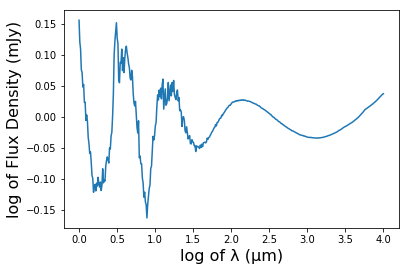

In [52]:
def show_SED(fluxvals):
    fig,ax=plt.subplots(1)
    ax.plot(np.log10(xvals), fluxvals)
    #ax.set_ylim(-6,5)
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

for i in range(10):
    show_SED(eigenseds[i])

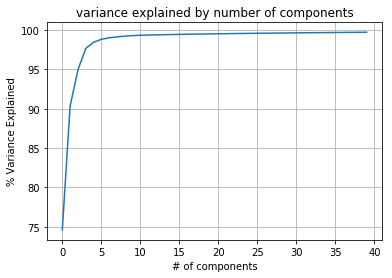

In [53]:
fig,ax=plt.subplots()
plt.ylabel('% Variance Explained')
plt.xlabel('# of components')
plt.title('variance explained by number of components')
plt.style.context('seaborn-whitegrid')
ax.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()
plt.show()

In [54]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [25]:
sfitdata=[]

for i in range(len(param_names)):
    sfitdata.append([])
    
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        sfitdata[i].append(modeldata)

In [68]:
def plotpcwpar_all(param):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    
    for coeffindex in range(4):
        pvals=[]
        cvals=[]
        for i in range(11):
            pvals.append(sfitdata[param][i][0])
            cvals.append(sfitdata[param][i][coeffindex+1])
            
        ax[coeffindex//2][coeffindex%2].scatter(pvals,cvals)
        ax[coeffindex//2][coeffindex%2].set_xlabel(param_names[param])
        ax[coeffindex//2][coeffindex%2].set_ylabel("w"+str(coeffindex))
    
    plt.subplots_adjust(hspace=0.6)
    plt.subplots_adjust(wspace=0.7)
    plt.show()
    print("principal component weight/parameter plots generated for ", param_names[param])

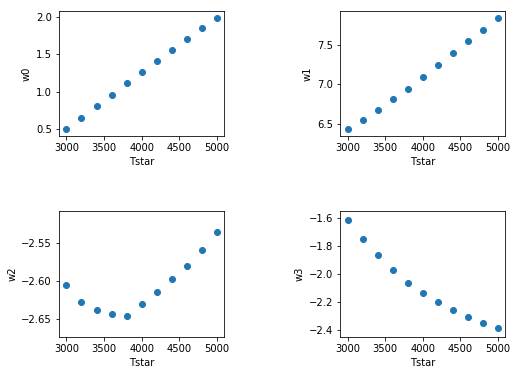

principal component weight/parameter plots generated for  Tstar


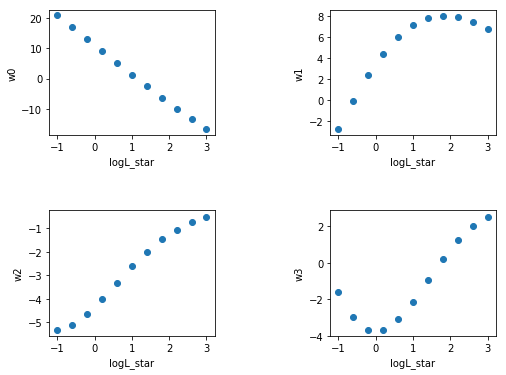

principal component weight/parameter plots generated for  logL_star


In [69]:
for i in range(2):
    plotpcwpar_all(i)

In [70]:
fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

In [71]:
X, y = load_pcwpar(0)
yerr=[x*0.01 for x in y]

kernel = np.var(y) * kernels.ExpSquaredKernel(10000**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.PolynomialKernel(1.7,15,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.PolynomialKernel(4,15,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(2**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(3**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

gp = george.GP(kernel)
gp.compute(X,yerr)

In [72]:
x0pred,x1pred=np.meshgrid(np.linspace(3000, 5000, 100),np.linspace(-1, 3, 100))
xpred=[]
for i in range(15):
    xpred.append(bases[i]*np.ones(10000))
xpred[0]=np.ndarray.flatten(x0pred)
xpred[1]=np.ndarray.flatten(x1pred)
x_pred=np.transpose(xpred)

In [73]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

# check hyperparameters
np.set_printoptions(suppress=True)
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

Initial ln-likelihood: -100862.57
[ 3.16145393 18.42068074  0.          0.         -0.4462871  -5.05145729
 -1.38629436  1.7        -3.21887582  4.         -3.21887582 -2.77258872
 -2.77258872  1.38629436  2.19722458  3.21887582]
[    4.85848649 10000.             1.             1.
     0.8            0.08           0.5            2.33964685
     0.2            7.3890561      0.2            0.25
     0.25           2.             3.             5.        ]


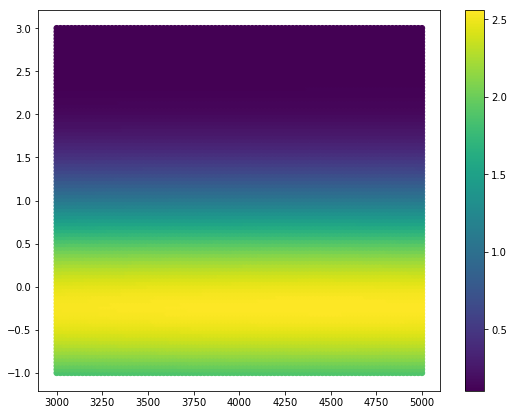

In [74]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.show()

In [ ]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

In [ ]:
# check hyperparameters
np.set_printoptions(suppress=True)
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.show()